C:\Users\sinha\AppData\Local\Temp\ipykernel_7372\667523423.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_7372\667523423.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_7372\667523423.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is

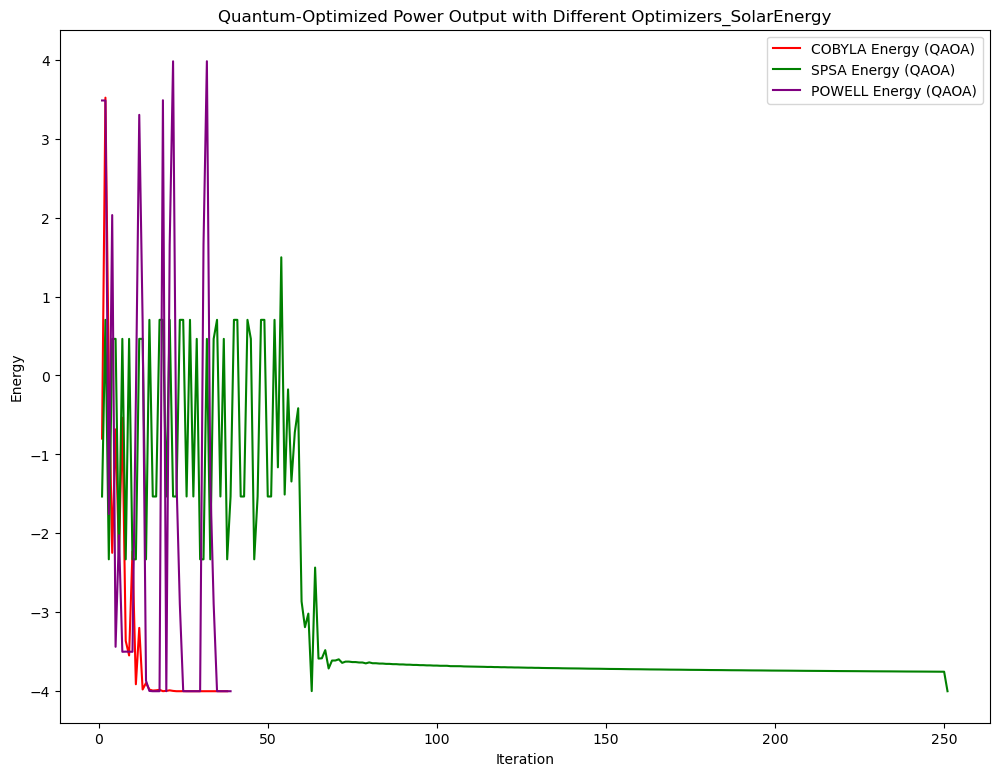

Optimizer: COBYLA
Maximized Quantum Power Output: 3.9999999604756487
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Optimizer: SPSA
Maximized Quantum Power Output: 4.0
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Optimizer: POWELL
Maximized Quantum Power Output: 3.999999999999991
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Classical Optimization:
Maximized Power Output (Classical): 125.25049366961211
Corresponding Data Point (Classical): V_oc = 84.34, I_sc = 27.905098, T = 36, G_theta = 965


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_optimization.translators import from_ising
from qiskit.quantum_info import SparsePauliOp

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance
r_s = 18.15  # Internal resistance
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define Pauli operators for QAOA (Negate to maximize power)
pauli_list = [("ZIII", -1), ("IZII", -1), ("IIZI", -1), ("IIIZ", -1)]
operator = SparsePauliOp.from_list(pauli_list)

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite= True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))
    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Function to run QAOA with different optimizers
def run_qaoa(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    
    # Define QAOA ansatz
    ansatz = QAOAAnsatz(operator, reps=3)
    qaoa_instance = QAOA(
        sampler=Sampler(),
        optimizer=optimizer,
        callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name)
    )
    return qaoa_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {
    'COBYLA': COBYLA(maxiter=100),
    'SPSA': SPSA(maxiter=100),
    'POWELL': POWELL(options={'maxiter': 100}) 
}

# Run QAOA with each optimizer
qaoa_results = {}
for optimizer_name, optimizer in optimizers.items():
    qaoa_results[optimizer_name] = run_qaoa(optimizer, optimizer_name)

# Plot results
colors = {'COBYLA': 'r', 'SPSA': 'g', 'POWELL': 'purple'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (QAOA)', color=colors[optimizer_name])

plt.title("Quantum-Optimized Power Output with Different Optimizers_SolarEnergy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
#plt.grid(True)
plt.savefig("power_output_comparison_multiple_optimizers_QAOA_final_SE1a.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) 
                           for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]

# Map quantum eigenvalues to data points and print results
max_eigenvalue_data = {}
for optimizer_name, result in qaoa_results.items():
    quantum_max_power_output = -result.eigenvalue.real  # Negate eigenvalue to match maximization
    max_eigenvalue_data[optimizer_name] = {"eigenvalue": quantum_max_power_output}

    # Find the data point corresponding to the maximum eigenvalue
    closest_index = None
    smallest_difference = float('inf')
    for i, (V_oc, I_sc, T, G_theta) in enumerate(zip(V_oc_values, I_sc_values, T_values, G_theta_values)):
        classical_power = power_output(V_oc, T, I_sc, G_theta)
        difference = abs(classical_power - quantum_max_power_output)
        if difference < smallest_difference:
            smallest_difference = difference
            closest_index = i

    if closest_index is not None:
        max_data_point = {
            "V_oc": V_oc_values[closest_index],
            "I_sc": I_sc_values[closest_index],
            "T": T_values[closest_index],
            "G_theta": G_theta_values[closest_index],
        }
        max_eigenvalue_data[optimizer_name]["data_point"] = max_data_point
        print(f"Optimizer: {optimizer_name}")
        print(f"Maximized Quantum Power Output: {quantum_max_power_output}")
        print(f"Corresponding Data Point: V_oc = {max_data_point['V_oc']}, "
              f"I_sc = {max_data_point['I_sc']}, T = {max_data_point['T']}, "
              f"G_theta = {max_data_point['G_theta']}\n")

# Classical optimization results
classical_max_power = max(classical_power_outputs)
classical_max_index = classical_power_outputs.index(classical_max_power)
classical_max_data_point = {
    "V_oc": V_oc_values[classical_max_index],
    "I_sc": I_sc_values[classical_max_index],
    "T": T_values[classical_max_index],
    "G_theta": G_theta_values[classical_max_index],
}
print("Classical Optimization:")
print(f"Maximized Power Output (Classical): {classical_max_power}")
print(f"Corresponding Data Point (Classical): V_oc = {classical_max_data_point['V_oc']}, "
      f"I_sc = {classical_max_data_point['I_sc']}, T = {classical_max_data_point['T']}, "
      f"G_theta = {classical_max_data_point['G_theta']}")


C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\861529656.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\861529656.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\861529656.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler``

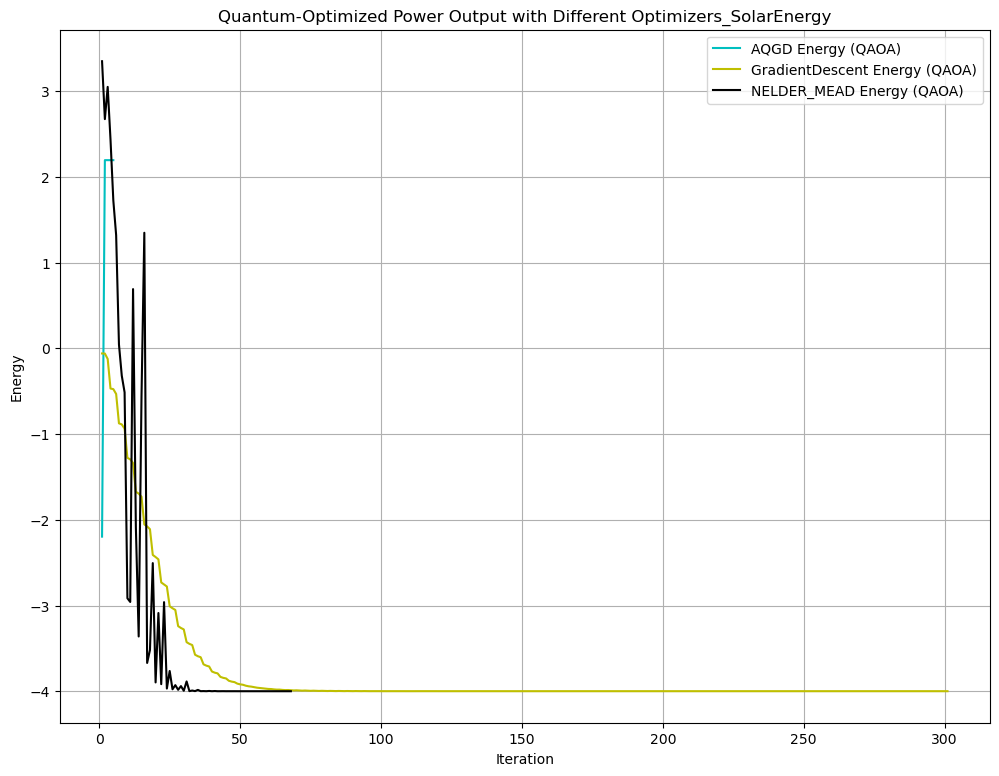

Optimizer: AQGD
Maximized Quantum Power Output: 2.1962313793248187
Corresponding Data Point: V_oc = 89.14, I_sc = 3.4738964, T = 28, G_theta = 169

Optimizer: GradientDescent
Maximized Quantum Power Output: 3.9996000085337857
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Optimizer: NELDER_MEAD
Maximized Quantum Power Output: 3.9999999796413213
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Classical Optimization:
Maximized Power Output (Classical): 125.25049366961211
Corresponding Data Point (Classical): V_oc = 84.34, I_sc = 27.905098, T = 36, G_theta = 965


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms.optimizers import AQGD, GradientDescent, NELDER_MEAD
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_optimization.translators import from_ising
from qiskit.quantum_info import SparsePauliOp

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance
r_s = 18.15  # Internal resistance
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define Pauli operators for QAOA (Negate to maximize power)
pauli_list = [("ZIII", -1), ("IZII", -1), ("IIZI", -1), ("IIIZ", -1)]
operator = SparsePauliOp.from_list(pauli_list)

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite= True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))
    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Function to run QAOA with different optimizers
def run_qaoa(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    
    # Define QAOA ansatz
    ansatz = QAOAAnsatz(operator, reps=3)
    qaoa_instance = QAOA(
        sampler=Sampler(),
        optimizer=optimizer,
        callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name)
    )
    return qaoa_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {'AQGD': AQGD(maxiter=100),'GradientDescent': GradientDescent(maxiter=100), 'NELDER_MEAD': NELDER_MEAD(maxiter=100)}

# Run QAOA with each optimizer
qaoa_results = {}
for optimizer_name, optimizer in optimizers.items():
    qaoa_results[optimizer_name] = run_qaoa(optimizer, optimizer_name)

# Plot results
colors = {'AQGD': 'c', 'GradientDescent': 'y', 'NELDER_MEAD': 'k'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (QAOA)', color=colors[optimizer_name])

plt.title("Quantum-Optimized Power Output with Different Optimizers_SolarEnergy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
#plt.grid(True)
plt.savefig("power_output_comparison_multiple_optimizers_QAOA_final_SE2a.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) 
                           for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]

# Map quantum eigenvalues to data points and print results
max_eigenvalue_data = {}
for optimizer_name, result in qaoa_results.items():
    quantum_max_power_output = -result.eigenvalue.real  # Negate eigenvalue to match maximization
    max_eigenvalue_data[optimizer_name] = {"eigenvalue": quantum_max_power_output}

    # Find the data point corresponding to the maximum eigenvalue
    closest_index = None
    smallest_difference = float('inf')
    for i, (V_oc, I_sc, T, G_theta) in enumerate(zip(V_oc_values, I_sc_values, T_values, G_theta_values)):
        classical_power = power_output(V_oc, T, I_sc, G_theta)
        difference = abs(classical_power - quantum_max_power_output)
        if difference < smallest_difference:
            smallest_difference = difference
            closest_index = i

    if closest_index is not None:
        max_data_point = {
            "V_oc": V_oc_values[closest_index],
            "I_sc": I_sc_values[closest_index],
            "T": T_values[closest_index],
            "G_theta": G_theta_values[closest_index],
        }
        max_eigenvalue_data[optimizer_name]["data_point"] = max_data_point
        print(f"Optimizer: {optimizer_name}")
        print(f"Maximized Quantum Power Output: {quantum_max_power_output}")
        print(f"Corresponding Data Point: V_oc = {max_data_point['V_oc']}, "
              f"I_sc = {max_data_point['I_sc']}, T = {max_data_point['T']}, "
              f"G_theta = {max_data_point['G_theta']}\n")

# Classical optimization results
classical_max_power = max(classical_power_outputs)
classical_max_index = classical_power_outputs.index(classical_max_power)
classical_max_data_point = {
    "V_oc": V_oc_values[classical_max_index],
    "I_sc": I_sc_values[classical_max_index],
    "T": T_values[classical_max_index],
    "G_theta": G_theta_values[classical_max_index],
}
print("Classical Optimization:")
print(f"Maximized Power Output (Classical): {classical_max_power}")
print(f"Corresponding Data Point (Classical): V_oc = {classical_max_data_point['V_oc']}, "
      f"I_sc = {classical_max_data_point['I_sc']}, T = {classical_max_data_point['T']}, "
      f"G_theta = {classical_max_data_point['G_theta']}")


C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\2150241921.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\2150241921.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),
C:\Users\sinha\AppData\Local\Temp\ipykernel_19664\2150241921.py:72: DeprecationWarning: The class ``qiskit.primitives.sampler.Sample

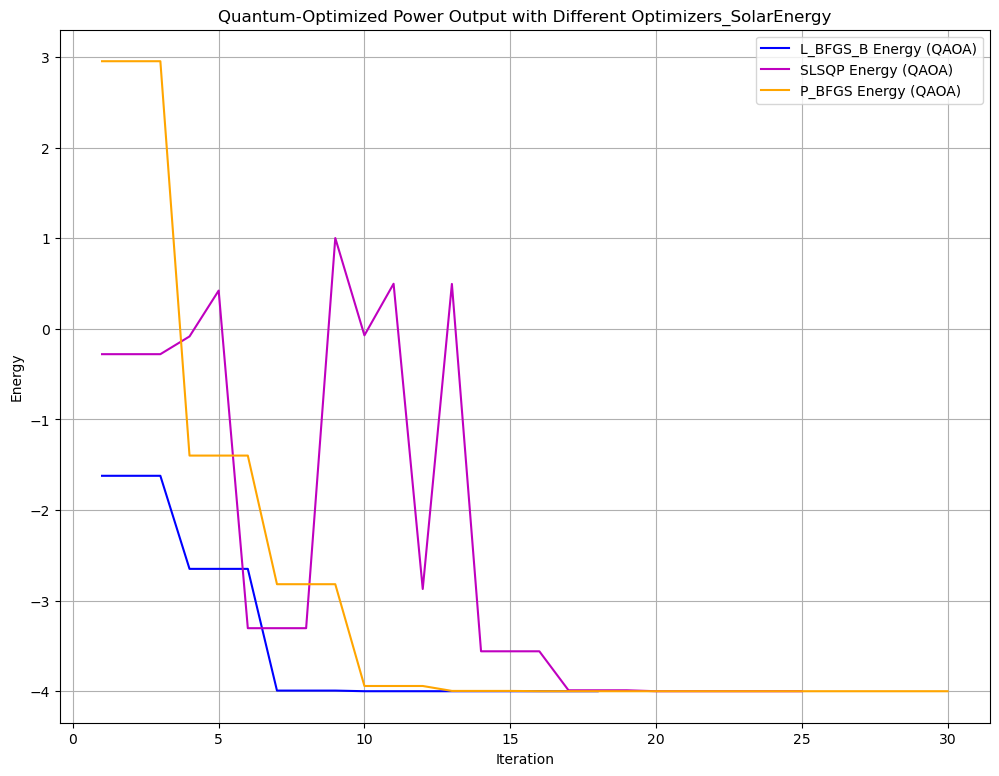

Optimizer: L_BFGS_B
Maximized Quantum Power Output: 3.999999999999991
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Optimizer: SLSQP
Maximized Quantum Power Output: 3.9999999998581246
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Optimizer: P_BFGS
Maximized Quantum Power Output: 3.9999999999999396
Corresponding Data Point: V_oc = 89.74, I_sc = 4.6434752, T = 27, G_theta = 238

Classical Optimization:
Maximized Power Output (Classical): 125.25049366961211
Corresponding Data Point (Classical): V_oc = 84.34, I_sc = 27.905098, T = 36, G_theta = 965


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP, P_BFGS
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_optimization.translators import from_ising
from qiskit.quantum_info import SparsePauliOp

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance
r_s = 18.15  # Internal resistance
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define Pauli operators for QAOA (Negate to maximize power)
pauli_list = [("ZIII", -1), ("IZII", -1), ("IIZI", -1), ("IIIZ", -1)]
operator = SparsePauliOp.from_list(pauli_list)

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite= True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)

# Set options for the quantum job
options = Options(optimization_level=3)

# Visualize optimization progress
iteration_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))
    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Function to run QAOA with different optimizers
def run_qaoa(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    
    # Define QAOA ansatz
    ansatz = QAOAAnsatz(operator, reps=3)
    qaoa_instance = QAOA(
        sampler=Sampler(),
        optimizer=optimizer,
        callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name)
    )
    return qaoa_instance.compute_minimum_eigenvalue(operator)

# Different optimizers
optimizers = {'L_BFGS_B': L_BFGS_B(maxiter=100),'SLSQP': SLSQP(maxiter=100),'P_BFGS': P_BFGS(options={'maxiter': 100})}

# Run QAOA with each optimizer
qaoa_results = {}
for optimizer_name, optimizer in optimizers.items():
    qaoa_results[optimizer_name] = run_qaoa(optimizer, optimizer_name)

# Plot results
colors = {'L_BFGS_B': 'b', 'SLSQP': 'm', 'P_BFGS': 'orange'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (QAOA)', color=colors[optimizer_name])

plt.title("Quantum-Optimized Power Output with Different Optimizers_SolarEnergy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.legend()
#plt.grid(True)
plt.savefig("power_output_comparison_multiple_optimizers_QAOA_final_SE3a.svg", dpi=300)
plt.show()
# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) 
                           for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]

# Map quantum eigenvalues to data points and print results
max_eigenvalue_data = {}
for optimizer_name, result in qaoa_results.items():
    quantum_max_power_output = -result.eigenvalue.real  # Negate eigenvalue to match maximization
    max_eigenvalue_data[optimizer_name] = {"eigenvalue": quantum_max_power_output}

    # Find the data point corresponding to the maximum eigenvalue
    closest_index = None
    smallest_difference = float('inf')
    for i, (V_oc, I_sc, T, G_theta) in enumerate(zip(V_oc_values, I_sc_values, T_values, G_theta_values)):
        classical_power = power_output(V_oc, T, I_sc, G_theta)
        difference = abs(classical_power - quantum_max_power_output)
        if difference < smallest_difference:
            smallest_difference = difference
            closest_index = i

    if closest_index is not None:
        max_data_point = {
            "V_oc": V_oc_values[closest_index],
            "I_sc": I_sc_values[closest_index],
            "T": T_values[closest_index],
            "G_theta": G_theta_values[closest_index],
        }
        max_eigenvalue_data[optimizer_name]["data_point"] = max_data_point
        print(f"Optimizer: {optimizer_name}")
        print(f"Maximized Quantum Power Output: {quantum_max_power_output}")
        print(f"Corresponding Data Point: V_oc = {max_data_point['V_oc']}, "
              f"I_sc = {max_data_point['I_sc']}, T = {max_data_point['T']}, "
              f"G_theta = {max_data_point['G_theta']}\n")

# Classical optimization results
classical_max_power = max(classical_power_outputs)
classical_max_index = classical_power_outputs.index(classical_max_power)
classical_max_data_point = {
    "V_oc": V_oc_values[classical_max_index],
    "I_sc": I_sc_values[classical_max_index],
    "T": T_values[classical_max_index],
    "G_theta": G_theta_values[classical_max_index],
}
print("Classical Optimization:")
print(f"Maximized Power Output (Classical): {classical_max_power}")
print(f"Corresponding Data Point (Classical): V_oc = {classical_max_data_point['V_oc']}, "
      f"I_sc = {classical_max_data_point['I_sc']}, T = {classical_max_data_point['T']}, "
      f"G_theta = {classical_max_data_point['G_theta']}")
